## Spotify Random Forest Classifer

For this project, I was interested in making use of my personal Spotify streaming data I requested directly from Spotify a few months ago. Any user can do this by going to the Spotify website, logging in, and then there is a page where you can submit a request for your own data. The insights I was interested in with this experiment had to do with predicting and understanding different features, such as artist, track title, and reason a song was started, and how they impact my likelihood to complete a song. To do this, I build a random forest classifier that uses a target of "trackdone", which is the Spotify reason code for a song ending in the data, and created a binary classification that stated whether the song was "completed" or "not completed". In the following code, you will see my EDA process to wrangle and clean the data to create a proper dataset for this model. You will also see the functionality of my model, and then ultimately the results as well as some visuals. Enjoy!

In this first block, I take all the json files that Spotify sends the data in and create an index for each file to be extended to. I then take the keys of these json dictionaries containing each record, and turn them into the headers for my CSV. Finally, I write the value in as records for each header to create my CSV file to be imported into the next step.

In [1]:


import json
import csv
import glob


#path to spotify json files
json_files = glob.glob('/Users/mason/Documents/Data Science/spotify audio json files/*.json')

#initialize index for all data from path
all_spotify_data = []

#read all json files in path
for file in json_files:
    with open(file, 'r', encoding = 'utf-8') as f:
        data = json.load(f)
        all_spotify_data.extend(data)

#get unique keys
keys = set()
for entry in all_spotify_data:
    keys.update(entry.keys())
keys = list(keys)

#write data to csv
with open('ms_spotify_streaming_histor_cleaned.csv','w', newline='', encoding = 'utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=keys)
    writer.writeheader()
    writer.writerows(all_spotify_data)
   

print("CSV File Created Successfully")

CSV File Created Successfully


This next block takes the CSV created from the script above. I then explore the dataset, remove any unnecessary columns, NA values, convert the timestamp to date time, and then do some reordering to make the dataset look how I want it to. Initially I was going to run this experiment on all the data in my streaming history available, but there was around 8 years of data containing over 200k records, which really slowed down the model run time. For the sake of this project, I chose to only explore data starting from the beginning of January, 2023.

In [2]:
import pandas as pd
from datetime import datetime, timedelta

#bring in CSV created from import json script
df = pd.read_csv('/Users/mason/Documents/Data Science/spotify audio json files/ms_spotify_streaming_history.csv')

#drop initial unnecessary columns
df = df.drop(columns=['offline','shuffle','audiobook_chapter_title','spotify_track_uri','incognito_mode',
                       'audiobook_uri','episode_show_name','audiobook_chapter_uri', 'conn_country',
                       'platform','episode_name','spotify_episode_uri','audiobook_title','ip_addr',
                       'offline_timestamp'])


#convert the timestamp to datetime               
df['ts'] = pd.to_datetime(df['ts'])
df['date'] = df['ts'].dt.date

df['seconds played'] = (df['ms_played'] / 1000).round()

#reorder the fields for visual purposes
df = df.reindex(columns=['date','ts','master_metadata_album_artist_name','master_metadata_track_name',
                        'master_metadata_album_album_name','reason_start','reason_end','skipped',
                        'seconds played','ms_played'])


#drop the original timestamp column now that the date is extracted
df= df.drop(columns=['ts','ms_played'])


#drop NA values from fields containing NAs (due to removed fields such as audiobook titles)
#for this analysis, I am only focused on music
df = df.dropna(subset=['master_metadata_album_artist_name','reason_start','reason_end'])

print(df.isna().sum())

#rename my fields to my liking
df = df.rename(columns={'master_metadata_album_artist_name': 'artist', 
                        'master_metadata_track_name': 'track title',
                        'master_metadata_album_album_name': 'album title'})

print(df.info())
print(df.head())

df['date'] = pd.to_datetime(df['date'])

start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2025-01-08')


filtered_df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]


#export to csv so I can view in excel if desired
df.to_csv('cleaned_data.csv',index=False)

filtered_df.to_csv('cleaned_data_01012023_01082025.csv', index=False)

/var/folders/g2/p_r1ypnd6lg4597fzb02ywxr0000gn/T/ipykernel_85471/2122438260.py:5: DtypeWarning: Columns (4,7,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/mason/Documents/Data Science/spotify audio json files/ms_spotify_streaming_history.csv')


date                                 0
master_metadata_album_artist_name    0
master_metadata_track_name           0
master_metadata_album_album_name     0
reason_start                         0
reason_end                           0
skipped                              0
seconds played                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 208085 entries, 0 to 208490
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            208085 non-null  object 
 1   artist          208085 non-null  object 
 2   track title     208085 non-null  object 
 3   album title     208085 non-null  object 
 4   reason_start    208085 non-null  object 
 5   reason_end      208085 non-null  object 
 6   skipped         208085 non-null  bool   
 7   seconds played  208085 non-null  float64
dtypes: bool(1), float64(1), object(6)
memory usage: 12.9+ MB
None
         date           artist     track ti

Now that I have my clean dataset, I can build my model in the following blocks. 

In [3]:
#Importing all libraries I will be using for my model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
import matplotlib.pyplot as plt 

In [4]:
#load dataset for model
def load_data(filepath, nrows=None):
    df = pd.read_csv(filepath, nrows=nrows)
    return df

In [5]:
# Load cleaned data
df = load_data('/Users/mason/Documents/Data Science/spotify audio json files/cleaned_data_01012023_01082025.csv')

In [6]:
#This function creates the target variable for the experiment. In this case it is marking a record as completed
#or not completed based on whether the reason end is "trackdone".
def create_target(df, target_col='completed', target_func=None):
    if target_func is not None:
        df[target_col] = df.apply(target_func, axis=1)
    else:
        df[target_col] = (df['reason_end'] == 'trackdone').astype(int)
    return df


In [7]:
# Create target
df = create_target(df)

In [8]:
#In this function, I encoded the features I would be using since they are categorical by assigning dummies to make them numerical.
def prepare_features(df, features, categorical_features):
    X = df[features]
    X_encoded = pd.get_dummies(X, columns=categorical_features)
    return X_encoded

In [9]:
#features can be modified for different experiments. *note: more features create a better model
# Prepare features
features = ['artist', 'track title', 'reason_start', 'album title']
categorical_features = ['artist', 'track title', 'reason_start', 'album title']
X_encoded = prepare_features(df, features, categorical_features)
y = df['completed']

In [10]:
#In this function, I create my train/test split for the model 
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [11]:
# Split data for training
X_train, X_test, y_train, y_test = split_data(X_encoded, y)

In [12]:
#In this function, I train the RF classifier and find the best hyperparameters for the model using grid search and cross validation.
def train_rf(X_train, y_train, param_grid=None):
    if param_grid is None:
        param_grid = {'max_depth': [5, 10, 20, None],'max_leaf_nodes': [10, 20, 50, 100, None]}
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validated ROC-AUC:", grid_search.best_score_)
    return grid_search.best_estimator_

In [13]:
#  Train model using random forest classifier
best_rf = train_rf(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'max_depth': None, 'max_leaf_nodes': 100}
Best cross-validated ROC-AUC: 0.8114243231241675


In [14]:

#I added this function after initial experimentation to create a better balance between recall and precision. Originally, my recall
#was very high, but precision was lower, so I wanted to build a help to choose the best probability to maximize precision while still keeping
#recall above a 0.7 at least.
def find_best_threshold_for_precision(y_test, y_proba, target_recall=0.7):
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    # Find all thresholds where recall >= target_recall
    possible = [(p, r, t) for p, r, t in zip(precisions, recalls, np.append(thresholds, 1.0)) if r >= target_recall]
    if possible:
        best = max(possible, key=lambda x: x[0])  # maximize precision
        best_precision, best_recall, best_threshold = best
        print(f"\nBest threshold for precision with recall >= {target_recall}: {best_threshold:.2f}")
        print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")
    else:
        best_threshold = 0.5
        print("\nNo threshold found with recall above target. Using 0.5.")
    return best_threshold, precisions, recalls, thresholds

In [15]:
#  Predict probabilities
y_proba = best_rf.predict_proba(X_test)[:, 1]

#  Find best threshold for precision with recall >= target. Target recall can be adjusted to fine tune the model
target_recall = 0.7 
best_threshold, precisions, recalls, thresholds = find_best_threshold_for_precision(y_test, y_proba, target_recall=target_recall)


Best threshold for precision with recall >= 0.7: 0.56
Precision: 0.617, Recall: 0.705


In [16]:
#In this function, I evaluate my model by returning my metrics for accuracy, precision, and recall at the best threshold. 
#I also added in a few visuals for additional insight as well as a list of the top 10 most imprtant features in my dataset that impact the models
#ability to predict whether a song will be completed or not. *Note: importance in the top 10 doesnt mean it is likely to impact 
#the positive class, it means it is just an important factor when classifying. ex: Knox is one of my favorite artists which makes sense
#why it is on there, but so is Taylor Swift, which also makes sense as I know I am almost guaranteed to hit skip for her music when it comes on.


def evaluate_model(model, X_test, y_test, best_threshold, precisions, recalls, thresholds):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= best_threshold).astype(int)

    print("\nTest Set Metrics at chosen threshold:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.3f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Completed', 'Completed'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Feature Importance
    importances = model.feature_importances_
    feature_names = X_test.columns
    feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False)
    print("\nTop 10 Feature Importances:")
    print(feat_imp.head(10))

    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp['feature'][:10][::-1], feat_imp['importance'][:10][::-1])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision')
    plt.plot(thresholds, recalls[:-1], label='Recall')
    plt.axvline(best_threshold, color='red', linestyle='--', label='Chosen Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold')
    plt.legend()
    plt.show()

    # Accuracy vs. Threshold Curve
    accuracies = [(y_test == (y_proba >= t).astype(int)).mean() for t in thresholds]
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, accuracies, label='Accuracy')
    plt.axvline(best_threshold, color='red', linestyle='--', label='Chosen Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.legend()
    plt.show()

    return y_pred, y_proba



Test Set Metrics at chosen threshold:
Accuracy:  0.760
Precision: 0.617
Recall:    0.705
ROC-AUC:   0.813

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.81      6420
           1       0.62      0.71      0.66      3129

    accuracy                           0.76      9549
   macro avg       0.73      0.75      0.74      9549
weighted avg       0.77      0.76      0.76      9549

Confusion Matrix:
 [[5049 1371]
 [ 923 2206]]


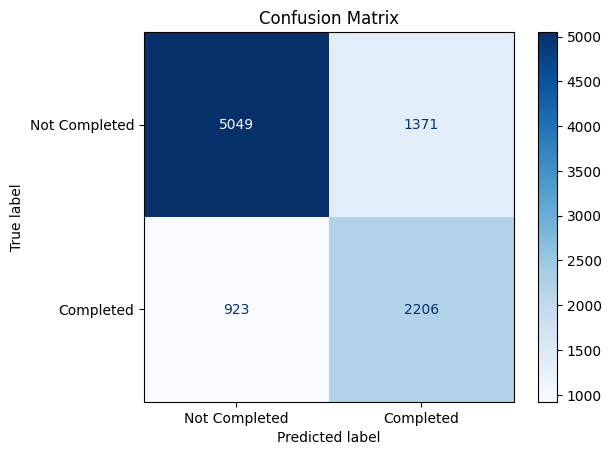


Top 10 Feature Importances:
                        feature  importance
13003       reason_start_fwdbtn    0.344335
13006    reason_start_trackdone    0.268624
13002     reason_start_clickrow    0.017545
1519                artist_Knox    0.012199
2034           artist_Novo Amor    0.008869
6330   track title_Hate My Guts    0.006999
2643        artist_Taylor Swift    0.006790
13001      reason_start_backbtn    0.005228
1569    artist_Lake Street Dive    0.004972
779           artist_Ed Sheeran    0.004525


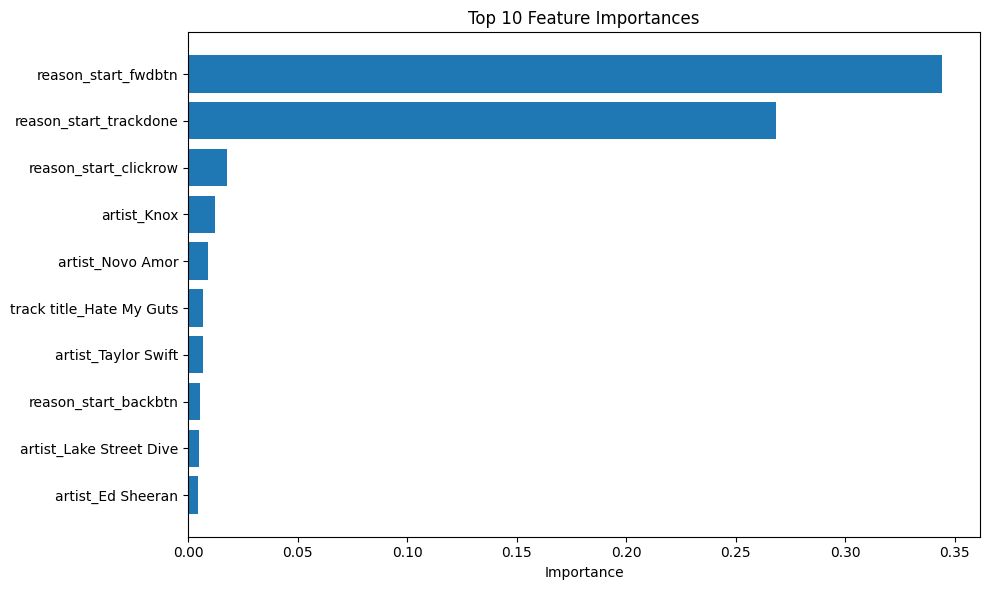

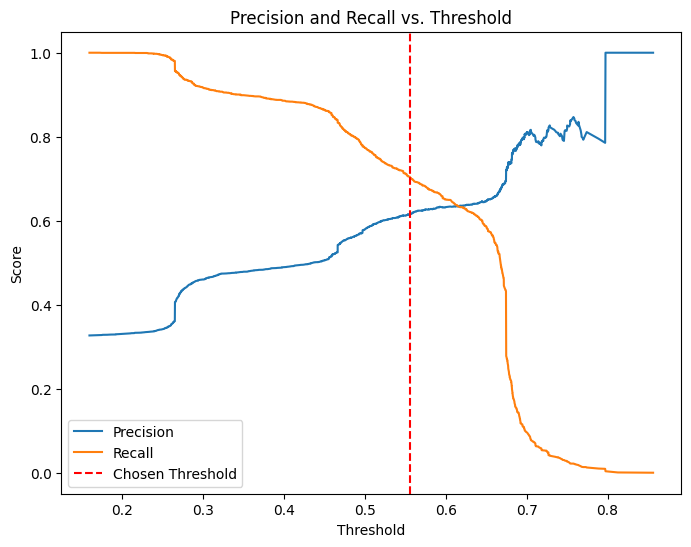

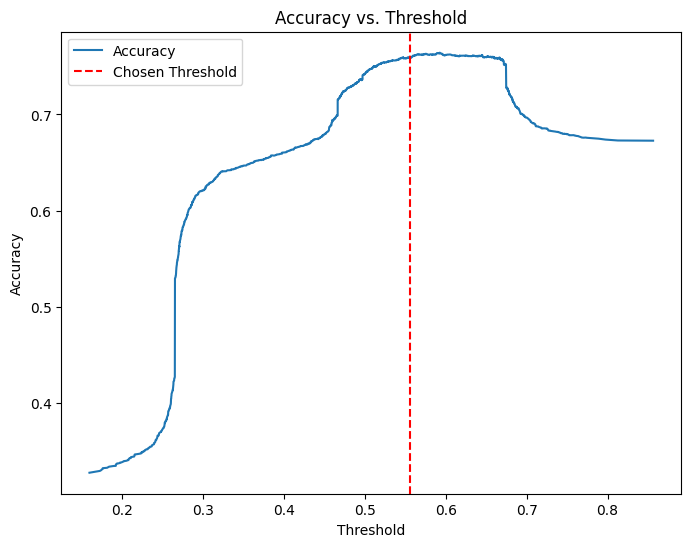

In [17]:
# Evaluate model at chosen threshold
y_pred, y_proba = evaluate_model(best_rf, X_test, y_test, best_threshold, precisions, recalls, thresholds)